In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization,Dropout
from tensorflow.keras.layers import Activation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from bs4 import BeautifulSoup
import re,string,unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense,LSTM,BatchNormalization
from keras.models import Sequential

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TRIDNT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TRIDNT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TRIDNT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Viewing And Analysing

In [96]:
raw_data = pd.read_csv(r"C:\Users\TRIDNT\Documents\Codes_and_Stuff\Datasets\socialmedia-disaster-tweets-DFE.csv",encoding='latin1')

In [97]:
df = raw_data.copy()
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [98]:
df['choose_one'].value_counts()
# we see that the relevant and non relevant or not equal. Also the can't decide are unnecesary for us so we remove it

choose_one
Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: count, dtype: int64

### Data Pre Processing

In [99]:
# Drop rows where the value in 'choose_one' column is "Can't Decide"
cleaned_df = df.copy()
cleaned_df = cleaned_df[cleaned_df['choose_one'] != "Can't Decide"]

# Reset the index after dropping the rows
cleaned_df.reset_index(drop=True, inplace=True)

cleaned_df_NRel = cleaned_df[cleaned_df['choose_one']=='Not Relevant']
print(cleaned_df_NRel.shape)
cleaned_df_Rel = cleaned_df[cleaned_df['choose_one']=='Relevant']
print(cleaned_df_Rel.shape)

cleaned_df_NRel_down = cleaned_df_NRel.sample(cleaned_df_Rel.shape[0])

cleaned_balanced_df = pd.concat([cleaned_df_NRel_down,cleaned_df_Rel])
# The values are balanced now
cleaned_balanced_df['choose_one'].value_counts()

(6187, 13)
(4673, 13)


choose_one
Not Relevant    4673
Relevant        4673
Name: count, dtype: int64

In [100]:
# take only the sentiment and text column which is of use to us and then encode relevant to 1 and non relavant to 0
data = cleaned_balanced_df[['choose_one','text']]
data['choose_one'] = LabelEncoder().fit_transform(data['choose_one'])

C:\Users\TRIDNT\AppData\Local\Temp\ipykernel_25760\1620854688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['choose_one'] = LabelEncoder().fit_transform(data['choose_one'])


### Text Pre Processing

In [101]:
trial_data = data.copy()

In [102]:
def text_preprocessing(text):
    # Clean text
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Lowercase and tokenize
    text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Stem and lemmatize
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    return ' '.join(lemmatized_tokens)  # Join tokens back into a single string

In [103]:
trial_data['text'] = trial_data['text'].apply(text_preprocessing)
trial_data.head()

,choose_one,text
2696,0,crush
2137,0,oh god that biggest gbbo catastroph ever seen ...
6572,0,laoi girl advertis new friend replac lovedup b...
1126,0,reason player ego caus mw3 cod champ that espo...
5636,0,popmech anoth tweet doubl post within 4 hr flo...


### Split into Train and Test Data

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X,Y = trial_data['text'],trial_data['choose_one']
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.2, random_state = 43)
print(f"Training Shape:{x_train.shape}\nTest Shape:{x_test.shape}")

Training Shape:(1869,)
Test Shape:(7477,)


#### Let us now create two different types of word converters - tfidf and countvectorizer

In [105]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

print('tfidf_train:',X_train_tfidf.shape)
print('tfidf_test:',X_test_tfidf.shape)

# cv=CountVectorizer(max_df=1,binary=False,ngram_range=(1,1))

# cv_train_reviews=cv.fit_transform(x_train)
# cv_test_reviews=cv.transform(x_test)

# print('BOW_cv_train:',cv_train_reviews.shape)
# print('BOW_cv_test:',cv_test_reviews.shape)

# Cv has very bad accuracy with this dataset with aroudn 50% only

tfidf_train: (1869, 7117)
tfidf_test: (7477, 7117)


### Create the Nueral Network Model


In [128]:
def model(x_train,x_test,y_train,y_test):
    NN_Model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    ])
    NN_Model.compile(optimizer=tf.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives()])
    from scipy.sparse import issparse

    # Check if the input data is sparse and convert it to a dense array if necessary
    if issparse(x_train):
        x_train = x_train.toarray()
    if issparse(x_test):
        x_test = x_test.toarray()

    NN_Model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

    print(NN_Model.evaluate(x_test,y_test))

    Y_pred = NN_Model.predict(x_test)
    y_pred_final = y_pred_final = (Y_pred > 0.5).astype(int).flatten()

    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred_final)
    from matplotlib import pyplot as plt
    import seaborn as sn
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

C:\Users\TRIDNT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - false_negatives_2: 274.6167 - false_positives_2: 224.4167 - loss: 0.8356 - true_negatives_8: 277.6167 - true_positives_11: 198.1833 - val_false_negatives_2: 3772.0000 - val_false_positives_2: 0.0000e+00 - val_loss: 0.6962 - val_true_negatives_8: 3705.0000 - val_true_positives_11: 0.0000e+00
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - false_negatives_2: 309.1667 - false_positives_2: 134.7500 - loss: 0.6936 - true_negatives_8: 374.3000 - true_positives_11: 156.6167 - val_false_negatives_2: 3771.0000 - val_false_positives_2: 0.0000e+00 - val_loss: 0.6935 - val_true_negatives_8: 3705.0000 - val_true_positives_11: 1.0000
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - false_negatives_2: 295.9333 - false_positives_2: 120.0833 - loss: 0.6819 - true_negatives_8: 386.2333 - true_positives_11: 172.5833 - val_false_negatives_2: 3722.0000 - val_false_positives_2: 6.0000 - val_loss: 0.6958 - val_true_negatives_8: 3699.0000 - val_tru

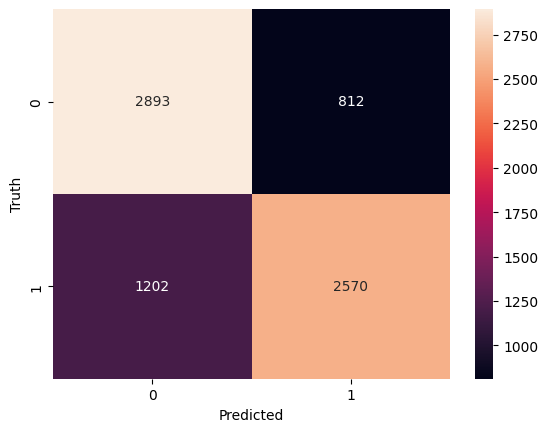

In [129]:
model(X_train_tfidf,X_test_tfidf,y_train, y_test)
# model(cv_train_reviews,cv_test_reviews,y_train, y_test)

### Ok the so final accuracy I'm getting with this datset is around 73%... i have tried various methods and I am not able to achieve a better accuracy so this is it I Guess : Final Accuracy = 73.4%